# Python 2.7,12 is used for this project.--- Qian Xiong

# Introduction & Load Data

We have energy usage data for a set of customers. The data are a panel of invoices over a period of 2 years for a set of customers. The description of the variables are shown as below:

    'Customer_id': Unique customer identifier
    'Invoicefromdt': Start date of bill period
    'Invoicetodt': End date of bill period
    'Invoicedate': Date of invoice
    'Kwh': Energy usage in kWh
    'Geoid1': Geographical identifier
    'Geoid2': Geographical identifier
    'Score': Customer propensity score

Our objective is to summarize the data using the descriptive statistics and plots in order to find some patterns or insights. Then build a predictive model to forecast the customers' next invoice amount.


In [1]:
# Import modules
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

In [2]:
# Machine learning modules
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

In [3]:
# Import data as a data frame
energy = pd.read_csv("test_usage_data.csv")
energy.info()
energy.head(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69874 entries, 0 to 69873
Data columns (total 8 columns):
customer_id      69874 non-null int64
invoicefromdt    69874 non-null object
invoicetodt      69874 non-null object
invoicedate      69874 non-null object
kwh              69874 non-null object
geoid1           69874 non-null int64
geoid2           69874 non-null int64
score            69874 non-null float64
dtypes: float64(1), int64(3), object(4)
memory usage: 4.3+ MB


,customer_id,invoicefromdt,invoicetodt,invoicedate,kwh,geoid1,geoid2,score
0,108728,2014-10-27,2014-11-25,2014-11-26,229.0,1,120,0.808390
1,108728,2015-03-03,2015-04-01,2015-04-03,242.0,1,120,0.060323
2,108732,2014-10-23,2014-11-21,2014-11-24,1103.0,1,120,0.876489
3,108732,2015-02-27,2015-03-30,2015-04-02,1489.0,1,120,0.545825
4,108739,2014-12-10,2015-01-16,2015-02-03,3423.0,4,121,0.174919


Seven potential variables may affect the response variable "kwh". We cannot build the predictive model based on the original start/end dates of bills period and invoice dates. We may consider extracting some useful information from the date records. 
In real-world, energy usage amounts may be impacted by the length of days for the bills period, the years/months/dates of the bills. Notice that the dates of the invoice are always within three days of the end dates of the bills period. It is reasonable to include the years, months and dates of the invoice bills in our model. We then create four columns in our dataset: "bill_days", "invoice_year", "invoice_month", "invoice_date".

In [4]:
# Create columns "invoice_year", "invoice_month", "invoice_date" to extract the years, months and days of the invoices
energy["invoice_year"] = pd.DatetimeIndex(energy["invoicedate"]).year
energy["invoice_month"] = pd.DatetimeIndex(energy["invoicedate"]).month
energy["invoice_date"] = pd.DatetimeIndex(energy["invoicedate"]).day

# Create a column "bill_days" to store the length of days for the bills
fromdt = pd.to_datetime(energy["invoicefromdt"])
todt = pd.to_datetime(energy["invoicetodt"])
period = pd.Series(todt - fromdt)
energy["bill_days"] = period.dt.days

energy.head(5)

,customer_id,invoicefromdt,invoicetodt,invoicedate,kwh,geoid1,geoid2,score,invoice_year,invoice_month,invoice_date,bill_days
0,108728,2014-10-27,2014-11-25,2014-11-26,229.0,1,120,0.808390,2014,11,26,29
1,108728,2015-03-03,2015-04-01,2015-04-03,242.0,1,120,0.060323,2015,4,3,29
2,108732,2014-10-23,2014-11-21,2014-11-24,1103.0,1,120,0.876489,2014,11,24,29
3,108732,2015-02-27,2015-03-30,2015-04-02,1489.0,1,120,0.545825,2015,4,2,31
4,108739,2014-12-10,2015-01-16,2015-02-03,3423.0,4,121,0.174919,2015,2,3,37


# Feature Exploration & Visualization

First detect correlation between features.

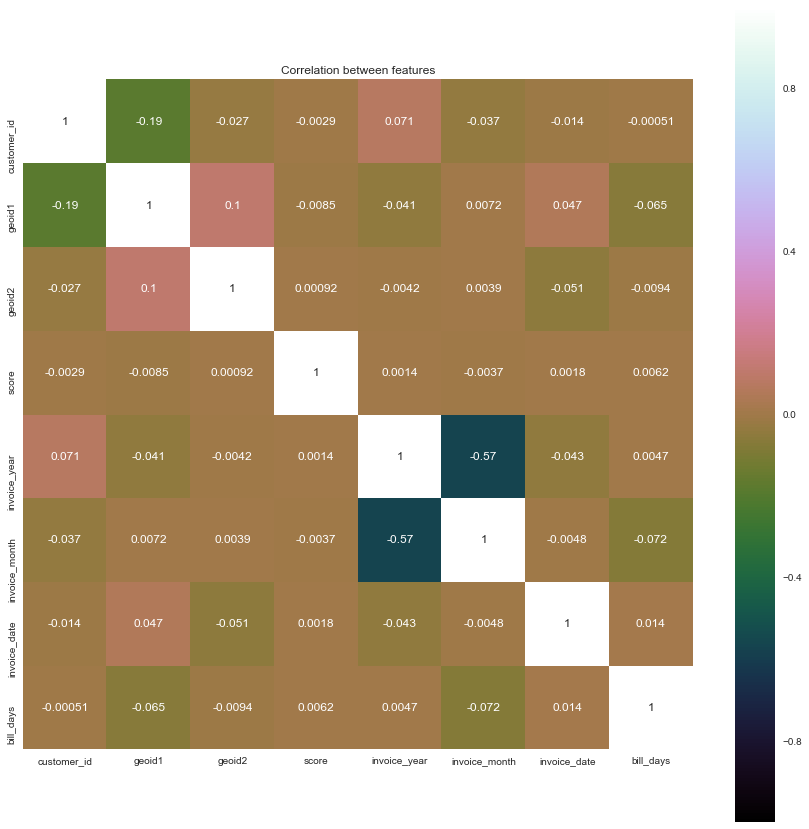

In [5]:
# Pairwise correlation heatmap
corr = energy.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr, vmax=1, square=True, annot=True, cmap='cubehelix')
plt.title('Correlation between features')

The correlation heatmap shows that the features are not strongly correlated. This is good from a point of view of feeding these features into your model because this means that each feature carries with it some unique information and there is no multicollinearity between the features. 

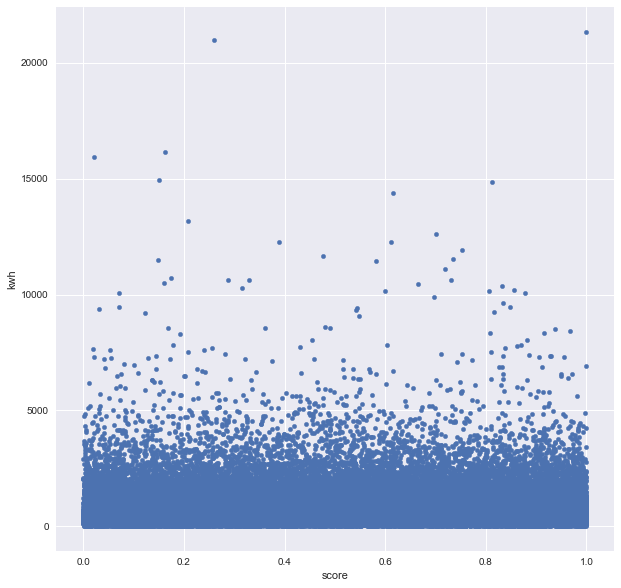

In [7]:
# There are missing values for "kwh".
energy_notnull = energy[energy["kwh"] != "(null)"]
# Convert the type of "kwh" from "object" to "float".
energy_notnull.kwh=energy_notnull.kwh.astype(float)

# Show the effect of "score" on "kwh".
energy_notnull.plot(kind="scatter", x="score", y="kwh", figsize=(10, 10))

There is no apparent pattern between "score" and "kwh". I'll still include feature "score" in our model.

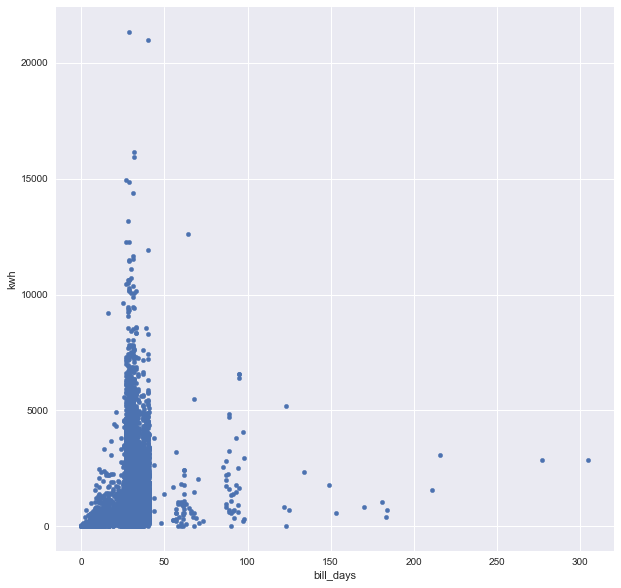

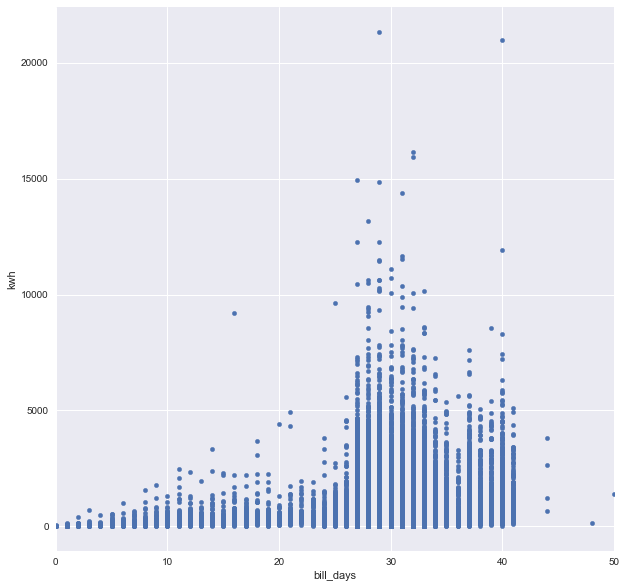

In [8]:
# Show the effect of "bill_days" on "kwh".
energy_notnull.plot(kind="scatter", x="bill_days", y="kwh", figsize=(10, 10))
energy_notnull.plot(kind="scatter", x="bill_days", y="kwh", figsize=(10, 10), xlim=(0, 50))

Most records have the "bill_days" less than 40. We can read from the plot that the "kwh" is highly correlated with "bill_days". For the records with "bill_days" less than 30, the value of "kwh" increases as days increases. Then it has a decreasing trend. It roughly matches the frequency of the reality. "bill_days" should be an important predictor feature.

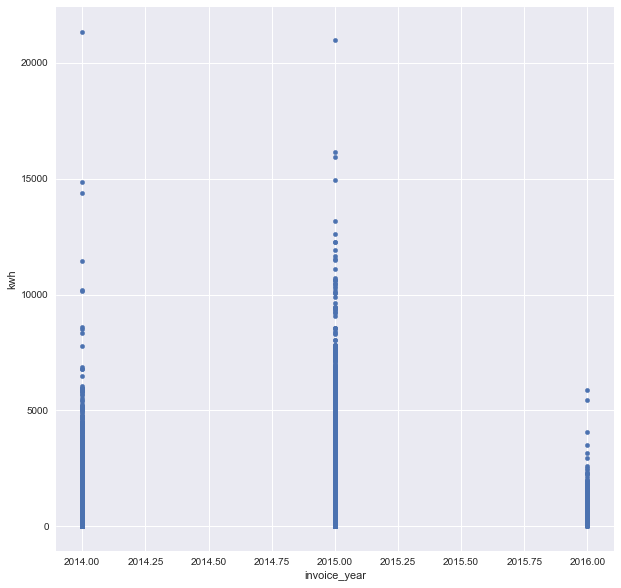

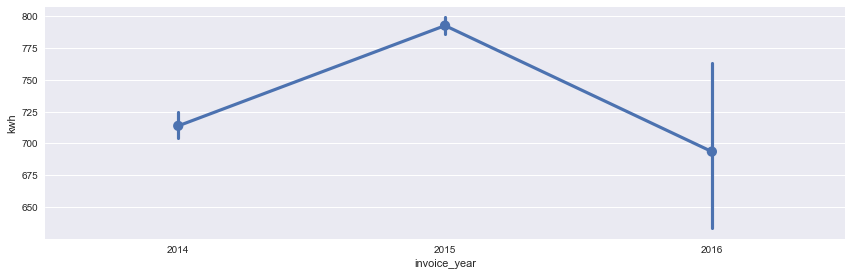

In [9]:
# Show the effect of "invoice_year" on "kwh".
energy_notnull.plot(kind="scatter", x="invoice_year", y="kwh", figsize=(10, 10))
sns.factorplot("invoice_year", "kwh", data=energy_notnull, aspect=3)


Feature "invoice_year" impacts the value of "kwh". The value of "kwh" in the year 2015 is higher than those in the year 2014. Not enough records may result in decreasing trend and large variation in 2016. 

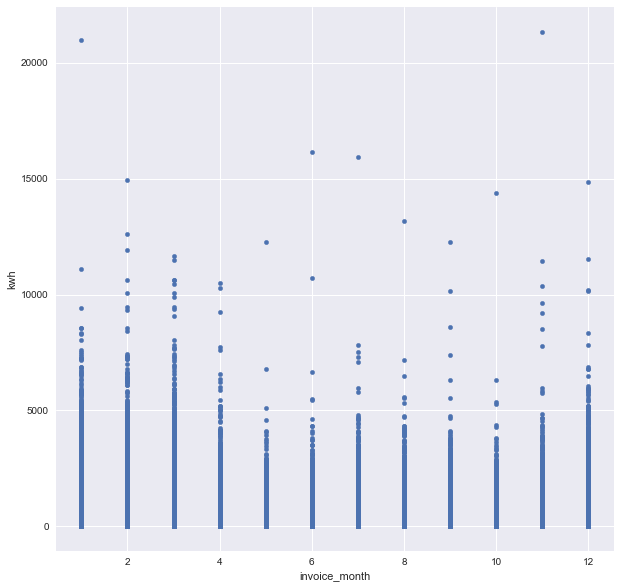

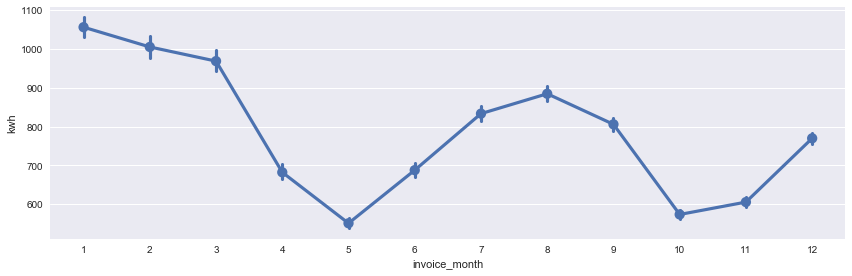

In [10]:
# Show the effect of "invoice_month" on "kwh".
energy_notnull.plot(kind="scatter", x="invoice_month", y="kwh", figsize=(10, 10))
sns.factorplot("invoice_month", "kwh", data=energy_notnull, aspect=3)

The "kwh" is highly correlated with "invoice_month". It has the pattern of high in summer and winter, which is due to the high rate of usage of air conditioners and heat utilities.

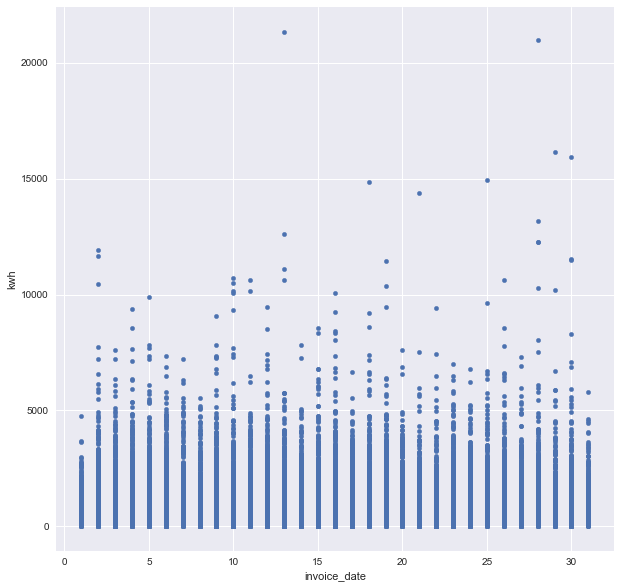

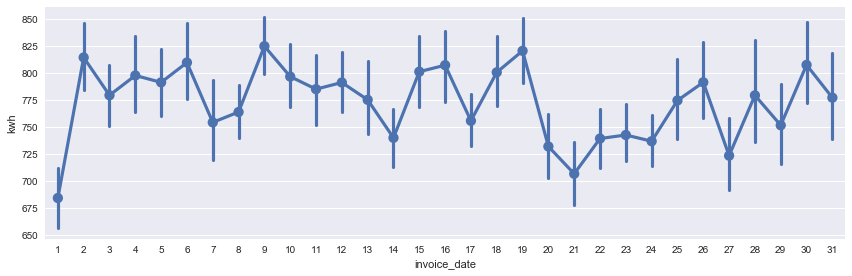

In [11]:
# Show the effect of "invoice_month" on "kwh".
energy_notnull.plot(kind="scatter", x="invoice_date", y="kwh", figsize=(10, 10))
sns.factorplot("invoice_date", "kwh", data=energy_notnull, aspect=3)

It seems no apparent pattern in the plots and we may say "invoice_date" is not the primary feature affecting "kwh".

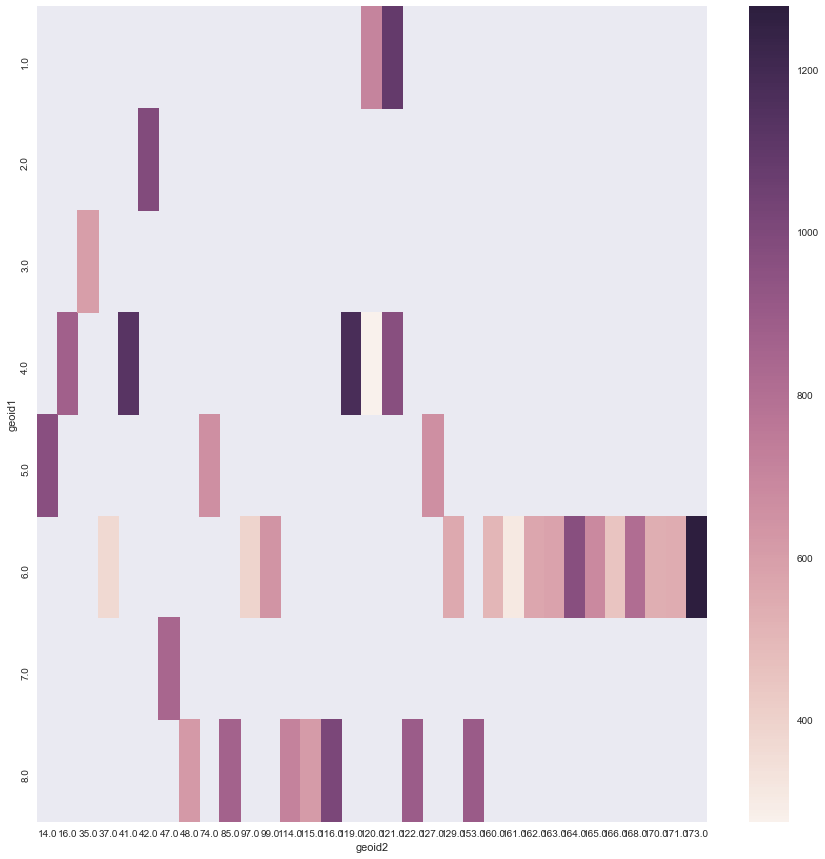

In [12]:
# Show the effect of "geoid1" and "geoid2" on "kwh".
geo_kwh=pd.DataFrame(columns=["geoid1","geoid2","kwh"])
for i in energy_notnull["geoid1"].unique():
    for j in energy_notnull["geoid2"].unique():
        mean_kwh=energy_notnull.kwh[(energy_notnull.geoid1==i) & (energy_notnull.geoid2==j)].mean()
        new=pd.DataFrame([[i,j,mean_kwh]],columns=["geoid1","geoid2","kwh"])
        geo_kwh=geo_kwh.append(new,ignore_index=True)

geo= geo_kwh.pivot("geoid1", "geoid2", "kwh")
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(geo)

We find that "geoid1" and "geoid2" interacts. The relationship between each of the interacting variables and the response variable depends on the value of the other interacting variable. It is appropriate to consider the interaction term.

# Feature Engineering & Cleaning

In [13]:
# Convert the "customer_id" to categorical variable
energy["customer_id"]=energy["customer_id"].astype("category")
# Based on exploration, add the interaction term of "geoid1" and "geoid2"
energy["inter_geo"]=energy["geoid1"]*energy["geoid2"]

We observe that there are missing values for "kwh". Now we may need to deal with them. Based on the above summaries, we know that "kwh" is highly correlated with "bill_days","invoice_year",'invoice_month","geoid1" and "geoid2". Thus it is reasonable to calculate the mean of each group in order to "guess" the missing values.

In [14]:
# Deal with missing values
energy.loc[energy["kwh"] != "(null)", "kwh_complete"] = energy.kwh[energy["kwh"] != "(null)"].astype(float)
energy_notnull = energy[energy["kwh"] != "(null)"]
energy_isnull = energy[energy["kwh"] == "(null)"]
null_list = energy_isnull.index.tolist()

# Fill the null values with the mean "kwh" values of the same "bill_days","invoice_year",
# 'invoice_month","geoid1" and "geoid2".
for i in null_list:
    guess = energy_notnull.kwh_complete[(energy_notnull.geoid1 == energy_isnull.geoid1[i])
                                        & (energy_notnull.geoid2 == energy_isnull.geoid2[i])
                                        & (energy_notnull.bill_days == energy_isnull.bill_days[i])
                                        & (energy_notnull.invoice_month == energy_isnull.invoice_month[i])
                                        & (energy_notnull.invoice_year == energy_isnull.invoice_year[i])].mean()
    energy.loc[i, "kwh_complete"] = guess

# Still has 4 missing values. 

energy_notnull1 = energy[energy.kwh_complete.notnull()]
energy_isnull1 = energy[energy.kwh_complete.isnull()]
null_list1 = energy_isnull1.index.tolist()

# Fill the null values with the mean "kwh" values of the same "bill_days","geoid1" and "geoid2".
for i in null_list1:
    guess = energy_notnull.kwh_complete[(energy_notnull.geoid1 == energy_isnull.geoid1[i])
                                        & (energy_notnull.geoid2 == energy_isnull.geoid2[i])
                                        & (energy_notnull.bill_days == energy_isnull1.bill_days[i])].mean()
    energy.loc[i, "kwh_complete"] = guess

energy.info()
energy["kwh_complete"].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69874 entries, 0 to 69873
Data columns (total 14 columns):
customer_id      69874 non-null category
invoicefromdt    69874 non-null object
invoicetodt      69874 non-null object
invoicedate      69874 non-null object
kwh              69874 non-null object
geoid1           69874 non-null int64
geoid2           69874 non-null int64
score            69874 non-null float64
invoice_year     69874 non-null int32
invoice_month    69874 non-null int32
invoice_date     69874 non-null int32
bill_days        69874 non-null int64
inter_geo        69874 non-null int64
kwh_complete     69874 non-null float64
dtypes: category(1), float64(2), int32(3), int64(4), object(4)
memory usage: 6.3+ MB


count    69874.000000
mean       775.109638
std        767.857346
min          0.000000
25%        327.000000
50%        569.220000
75%        970.000000
max      21339.000000
Name: kwh_complete, dtype: float64

In [15]:
# Drop unnecessary columns for modeling
energy.drop(["invoicefromdt", "invoicetodt", "invoicedate", "kwh"], axis=1, inplace=True)
energy.head(5)

,customer_id,geoid1,geoid2,score,invoice_year,invoice_month,invoice_date,bill_days,inter_geo,kwh_complete
0,108728,1,120,0.808390,2014,11,26,29,120,229.0
1,108728,1,120,0.060323,2015,4,3,29,120,242.0
2,108732,1,120,0.876489,2014,11,24,29,120,1103.0
3,108732,1,120,0.545825,2015,4,2,31,120,1489.0
4,108739,4,121,0.174919,2015,2,3,37,484,3423.0


# Modeling

We will consider multiple regression techniques. Here we use the cross-validation with the criteria negative MSE to compare the performance of the different techniques. The larger the negative MSE, the better the technique performs.

In [17]:
Var=list(energy)
print Var
# Define cross-validation fucntion
def Model_CV(arg,X,Y):
    scores=cross_val_score(arg,X,Y,cv=20, scoring='neg_mean_squared_error')     #negative MSE
    return scores.mean()

['customer_id', 'geoid1', 'geoid2', 'score', 'invoice_year', 'invoice_month', 'invoice_date', 'bill_days', 'inter_geo', 'kwh_complete']


In [58]:
# LinearRegression
# Simplest model
arg=LinearRegression()
Model_CV(arg,energy[Var[:9]],energy[Var[9]])

-572721.12036918884

In [59]:
#Lasso Regression
# Control of overfitting
a=np.linspace(0.1,1,num=10)
for i in a:
    arg=Lasso(alpha=i,random_state=2017)
    score=Model_CV(arg,energy[Var[:9]],energy[Var[9]])
    print i, score

0.1 -572722.700422
0.2 -572724.767977
0.3 -572727.3231
0.4 -572730.365713
0.5 -572733.895583
0.6 -572737.91346
0.7 -572742.418214
0.8 -572746.327844
0.9 -572748.948825
1.0 -572750.676674


The larges score -572722.700422 is reached with alpha=0.1.

In [60]:
# Ridge Regression
# Control of overfitting
a=np.linspace(0.1,1,num=10)
for i in a:
    arg=Ridge(alpha=i,random_state=2017)
    score=Model_CV(arg,energy[Var[:9]],energy[Var[9]])
    print i, score

0.1 -572721.119508
0.2 -572721.118647
0.3 -572721.117787
0.4 -572721.116927
0.5 -572721.116067
0.6 -572721.115207
0.7 -572721.114348
0.8 -572721.113489
0.9 -572721.112631
1.0 -572721.111772


The larges score -572721.111772 is reached with alpha=1.

In [61]:
# RandomForestRegressor
arg=RandomForestRegressor(n_estimators=100, random_state=2017)
Model_CV(arg,energy[Var[:9]],energy[Var[9]]) 

-517487.96505803394

In [ ]:
# SVR(Support Vector Regression)
arg=SVR(kernel="linear")
Model_CV(arg,energy[Var[:9]],energy[Var[9]]) 

-6827.0000

By comparing the scores for different techniques, Support Vector Regression performs best for prediction. 

We also tried the square-root transformation of the variable "kwh" since it varies from 0 to 21339. And in the scatter plot of "invoice_date" and "kwh", we observed some extremely large values. However, it leads to smaller scores compared with the ones with the original response variable. Thus we prefer the random forest regressor based on the originial "kwh" values to predict a customer's next invoice amount (kwh).

# More Discussion

There are other ways to improve the prediction accuracy. 

We may consider fitting the linear mixed model, which is a statistical model containing both fixed effects and random effects. It is useful for repeated measurements for each experimental unit. We could treat the "customer_id" as a random effect and other features as fixed effects. Then we can fit linear mixed model and then make predictions.

Additional treatments may be other appropriate scalings or transformations of the features and response variable.